# Image analysis for control charts for Power Bed Laser Fusion

## Data manipolation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "data/stacked_data.csv"
df = pd.read_csv(file_path)

df.head()

,t,x,y,z,layer_id,sensor0,sensor1,temp,track_id,track_orient,pos_rel,t_rel
0,80444000.0,26.048,-66.325,21.12,528,801.0,798.0,1591.9,0,119,0.00000,0.0
1,80444010.0,26.054,-66.332,21.12,528,803.0,798.0,1594.6,0,119,0.00816,10.0
2,80444020.0,26.061,-66.338,21.12,528,789.0,785.0,1593.3,0,119,0.01633,20.0
3,80444030.0,26.063,-66.342,21.12,528,785.0,790.0,1580.7,0,119,0.02449,30.0
4,80444040.0,26.066,-66.345,21.12,528,785.0,790.0,1580.7,0,119,0.03265,40.0


Generate a temperature matrix

In [2]:
# first create pivot table and then crop
def generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round=1):
    temperature_matrices = []
    for layer_id in layer_ids:
        layer_df = df[df['layer_id'] == layer_id]

        #layer_df['x_bin'] = layer_df['x'].round(digits_round)
        #layer_df['y_bin'] = layer_df['y'].round(digits_round)
        layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
        layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)

        # Create a pivot table with the grouped x and y values with mean
        temperature_matrix = layer_df.pivot_table(index='y_bin', columns='x_bin', values='temp', aggfunc='median')
        
        # Fill missing values with interpolation or a default value
        temperature_matrix = temperature_matrix.interpolate(axis=0).interpolate(axis=1)
        
        # Crop the temperature matrix based on the x_range and y_range
        cropped_matrix = temperature_matrix.loc[y_range[0]:y_range[1], x_range[0]:x_range[1]]
        temperature_matrices.append(cropped_matrix.to_numpy())
    return np.array(temperature_matrices)

In [4]:
digits_round = 1
x_range = (26.292, 38.089)
y_range = (-66.633, -54.62)
layer_ids = [224, 225, 226, 227, 228, 324, 325, 326, 327, 328, 424, 425, 426, 427, 428, 524, 525, 526, 527, 528, 569, 570, 571, 572, 573]
list_25l = generate_temperature_matrices_v1(df, layer_ids, x_range, y_range, digits_round)

C:\Users\Utente\AppData\Local\Temp\ipykernel_15084\437303520.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['x_bin'] = np.floor(layer_df['x'] * (10 ** digits_round)) / (10 ** digits_round)
C:\Users\Utente\AppData\Local\Temp\ipykernel_15084\437303520.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['y_bin'] = np.floor(layer_df['y'] * (10 ** digits_round)) / (10 ** digits_round)


In [5]:
list_25l.shape

(25, 120, 118)

rowwise pca

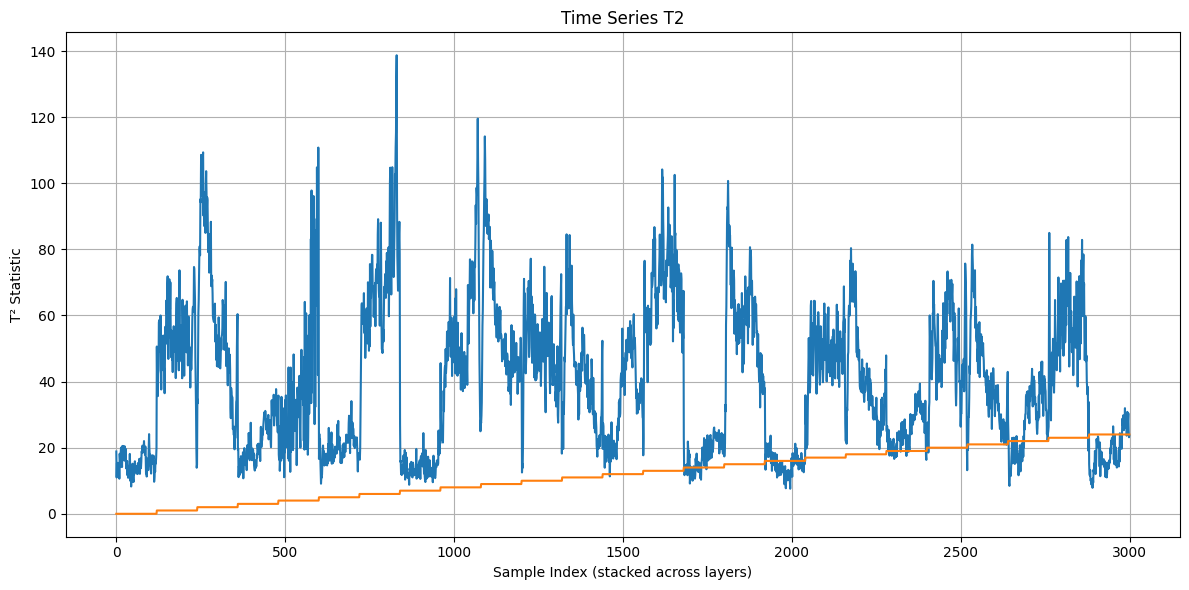

In [17]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

def global_pca_hotelling_df(list_25l, n_components=0.90):
    # Step 1: Stack all matrices vertically
    X_all = np.vstack(list_25l)  # shape: (25*M, N)

    # Step 2: Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_all)
    std_devs = np.sqrt(pca.explained_variance_)

    # Step 3: Compute Hotelling T²
    T2 = np.sum((X_pca / std_devs) ** 2, axis=1)

    # Step 4: Build matrix index column
    rows_per_matrix = list_25l[0].shape[0]
    matrix_indices = np.concatenate([
        np.full(rows_per_matrix, i) for i in range(len(list_25l))
    ])

    # Step 5: Return DataFrame
    df = pd.DataFrame({
        'T2': T2,
        'layer_id': matrix_indices
    })
    return df
output = global_pca_hotelling_df(list_25l)

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.plot(output, label='Hotelling T²')
plt.xlabel('Sample Index (stacked across layers)')
plt.ylabel('T² Statistic')
plt.title('Time Series T2')
plt.grid(True)
plt.tight_layout()
plt.show()

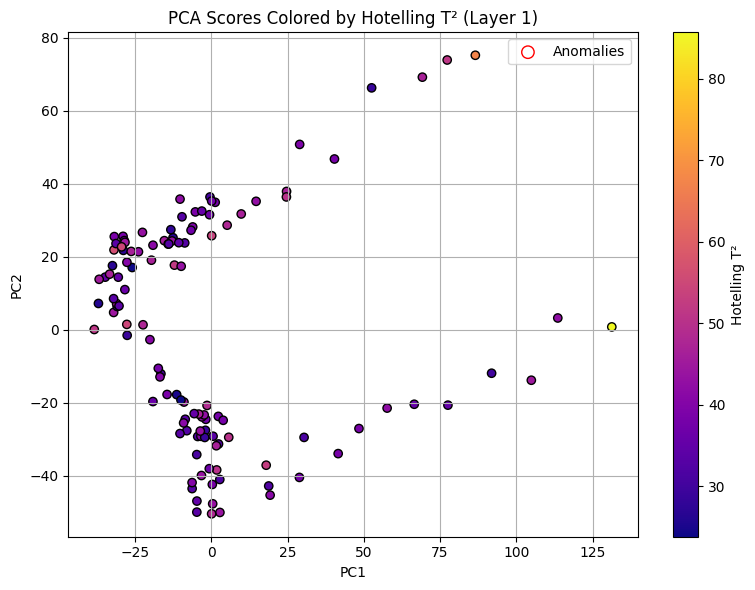

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import f

def plot_pca_hotelling_layer(matrix, confidence=0.95):
    # Step 1: Apply PCA (keep all components for accurate T², but plot first 2)
    pca = PCA(n_components=0.90)
    scores = pca.fit_transform(matrix)
    std_devs = np.sqrt(pca.explained_variance_)
    
    # Step 2: Compute Hotelling T² for each sample
    t2 = np.sum((scores / std_devs) ** 2, axis=1)

    # Step 3: Plot in first 2 PCs
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(scores[:, 0], scores[:, 1], c=t2, cmap='plasma', edgecolor='k')
    plt.colorbar(sc, label="Hotelling T²")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA Scores Colored by Hotelling T² (Layer 1)')
    plt.grid(True)

    # Step 4: Plot threshold ellipse (optional)
    n, p = matrix.shape[0], scores.shape[1]
    f_crit = f.ppf(confidence, p, n - p)
    t2_thresh = (p * (n - 1) / (n - p)) * f_crit

    # Show samples with T² > threshold
    outliers = np.where(t2 > t2_thresh)[0]
    plt.scatter(scores[outliers, 0], scores[outliers, 1], edgecolors='red', facecolors='none', s=80, label='Anomalies')

    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca_hotelling_layer(list_25l[0])
